In [1]:
from dataloader import normalize_image, DAVIS_test, OneVideoDataset
from model import GeneralExtra, ResBlock
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random
from ModelInfer import ModelInfer

In [2]:
data_set = OneVideoDataset()
test_set = DAVIS_test()
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx = next(iter(data_loader))
pre_idx, curr_idx

(tensor([56]), tensor([57]))

Text(0.5, 1.0, 'First Frame in test set')

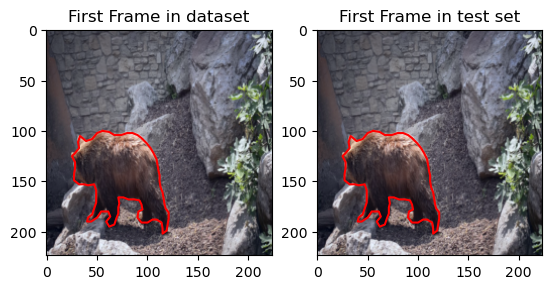

In [4]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(first_frame[index].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in dataset")
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(test_set[0][0].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in test set")

Text(0.5, 1.0, 'Curr Frame')

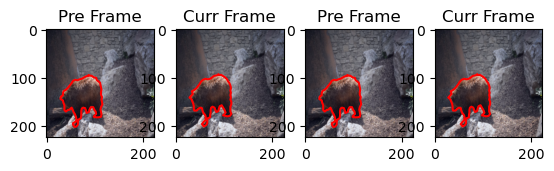

In [5]:
index = 0
plt.subplot(1, 4, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 4, 3)
plt.imshow(normalize_image(test_set[pre_idx][0].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 4)
plt.imshow(normalize_image(test_set[curr_idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')

In [6]:
# extra_block = ResBlock(384, 384)
feat_dim = 384
extra_block = nn.Sequential(
        nn.Conv2d(
            in_channels=feat_dim,
            out_channels=feat_dim,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=feat_dim,
            out_channels=feat_dim,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
    )
model = GeneralExtra(extra_block)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
model = model.cuda()
results = model(
    first_frame.cuda(),
    first_boundary.cuda(),
    pre_frame.cuda(),
    curr_frame.cuda(),
    pre_boundary.cuda(),
)

/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
order_loss(results[-1], curr_boundary.cuda())

tensor(6.1894, device='cuda:0', grad_fn=<DivBackward0>)

In [9]:
model_infer = ModelInfer(test_set)

In [10]:
model_infer.infer_model(model)

In [17]:
model_infer.get_infer_iou(0)

KeyError: 0

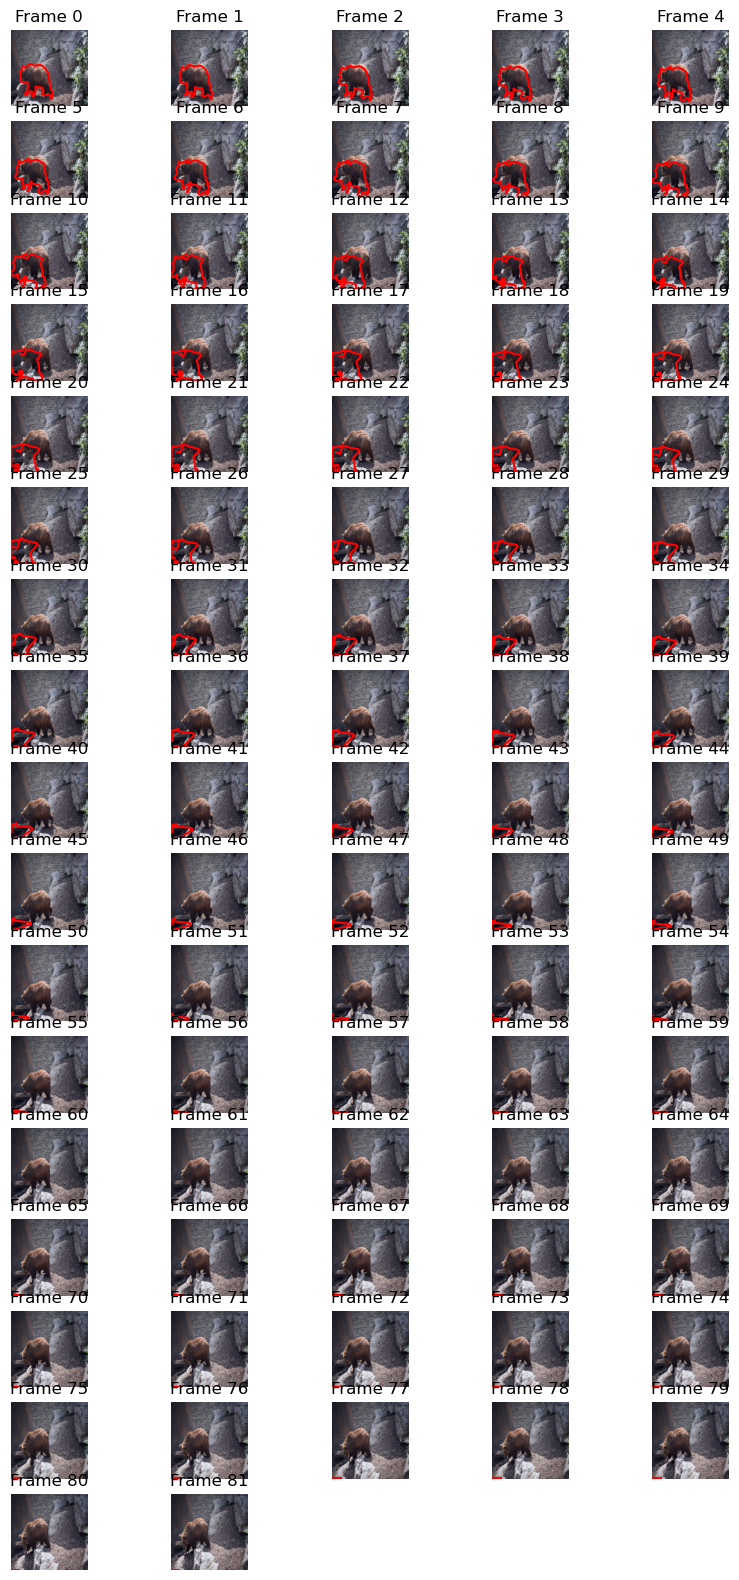

0.10995080376533063

In [11]:
model_infer.show_infer_result(0)

In [12]:
feat_dim = 384
extra_block = nn.Sequential(
        nn.Conv2d(
            in_channels=feat_dim,
            out_channels=feat_dim,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=feat_dim,
            out_channels=feat_dim,
            kernel_size=3,
            padding=1,
            stride=1,
        ),
        nn.ReLU(),
    )
model = GeneralExtra(extra_block).cuda()
model_infer = ModelInfer(test_set)
data_set = OneVideoDataset()
loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
dict_loss = {}
dict_iou = {}
interval_epochs = 50
interval_num = 155
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
test_set = DAVIS_test()
model_infer = ModelInfer(test_set)
epoch_index = 0

In [14]:
for interval in range(interval_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in data_loader:
            pre_idx = pre_idx.item()
            curr_idx = curr_idx.item()
            pre_boundary = model_infer.get_boundary(pre_idx)
            pre_boundary = pre_boundary.unsqueeze(0).to("cuda")
            first_boundary = first_boundary.to("cuda")
            first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary = (
                first_frame.to("cuda"),
                first_boundary.to("cuda"),
                pre_frame.to("cuda"),
                curr_frame.to("cuda"),
                pre_boundary.to("cuda"),
                curr_boundary.to("cuda"),
            )
            optimizer.zero_grad()
            results = model(first_frame, first_boundary, pre_frame, curr_frame, pre_boundary)
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * loss_func(results[i], curr_boundary)
            mean_loss += loss.item()
            # nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            loss.backward()
            optimizer.step()
        mean_loss /= len(data_loader)
        epoch_index += 1
        print(f"Epoch {epoch_index}, Loss: {mean_loss:.2f}")
        dict_loss[epoch_index] = mean_loss
    model_infer.infer_model(model)
    iou = model_infer.show_infer_result(0)
    dict_iou[epoch_index] = iou
    print(f"Epoch {epoch_index}, IOU: {iou:5f}")
    if interval_epochs > 100:
        interval_epochs = 50
    elif interval_epochs > 5:
        interval_epochs -= 5

Epoch 1, Loss: 8.67
Epoch 2, Loss: 8.21


KeyboardInterrupt: 